In [62]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy
!pip install line_profiler
%load_ext line_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


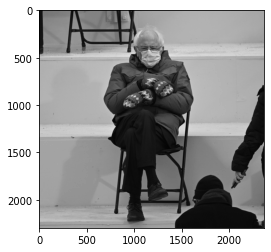

In [63]:
bgr_bernie = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Computer Vision/CW2/bernie.jpeg")
rgb_bernie = cv2.cvtColor(bgr_bernie, cv2.COLOR_BGR2RGB)
gray_bernie = cv2.cvtColor(rgb_bernie, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_bernie, cmap='gray')

In [64]:
def plot_image_row(title: str, images: dict) -> None:
  """
  Function takes in a dictionary of iamges to plot
  with format {'plot_title': np.ndarray}
  """
  fig = plt.figure(figsize = (4*len(images),5))
  fig.suptitle(title, fontsize=16)
  for i, img_key in enumerate(images.keys()):
    ax = fig.add_subplot(1,len(images),i+1)
    ax.axis('off')
    ax.imshow(images[img_key], cmap='gray')
    ax.set_title(img_key)
  plt.show()

# 1. Interest point (Keypoint) Detection [9 marks]

## 1.1 Define Harris Corner Detector [7 marks]

In [65]:
# SCALE = 1
# DELTA = 0
# DDEPTH = cv2.CV_16S

# def HarrisPointsDetector(gray_img: np.ndarray, window: int) -> np.ndarray:
#   half_window = window//2
#   corner_strength_img = np.zeros(gray_img.shape)
#   grad_x = cv2.Sobel(gray_img, DDEPTH, 1, 0, ksize=3,
#                      scale=SCALE, delta=DELTA,
#                      borderType=cv2.BORDER_REPLICATE)
#   grad_y = cv2.Sobel(gray_img, DDEPTH, 0, 1, ksize=3,
#                      scale=SCALE, delta=DELTA,
#                      borderType=cv2.BORDER_REPLICATE)
#   for y, row in enumerate(corner_strength_img):
#     for x, _ in enumerate(row):
#       M = np.zeros((2, 2))
#       gauss_mask = cv2.getGaussianKernel(5, sigma=0.5) 
#       for window_y in range(-half_window, half_window+1):
#         adjusted_y = y+window_y
#         if adjusted_y < 0 or adjusted_y >= gray_img.shape[0]:
#           break
#         for window_x in range(-half_window, half_window+1):
#           adjusted_x = x+window_x
#           gauss_weight = (gauss_mask[half_window+window_y]*gauss_mask[half_window+window_x])[0]
#           if adjusted_x < 0 or adjusted_x >= gray_img.shape[1]:
#             break
#           M_i = gauss_weight*np.array([[grad_x[adjusted_y,adjusted_x]**2,
#                           grad_x[adjusted_y,adjusted_x]*grad_y[adjusted_y,adjusted_x]],
#                           [grad_x[adjusted_y,adjusted_x]*grad_y[adjusted_y,adjusted_x],
#                           grad_y[adjusted_y,adjusted_x]**2]])
#           M += M_i
#       corner_strength_img[y,x] = np.linalg.det(M) - 0.1*(np.trace(M))**2
#   return corner_strength_img

In [66]:
ALPHA = 0.1
NON_MAX_WINDOW = 3
HARRIS_THRESH = 0
def HarrisPointsDetector(gray_img: np.ndarray) -> np.ndarray:
  blurred_gray_img = scipy.ndimage.gaussian_filter(gray_img, sigma=0.5,
                                                   output=np.float32)
  Ix = scipy.ndimage.sobel(blurred_gray_img, 1)
  Iy = scipy.ndimage.sobel(blurred_gray_img, 0)
  Ix_squared = Ix**2
  Iy_squared = Iy**2
  IxIy = Ix*Iy
  gIx_squared = scipy.ndimage.gaussian_filter(Ix_squared, sigma=0.5, radius=2)
  gIy_squared = scipy.ndimage.gaussian_filter(Iy_squared, sigma=0.5, radius=2)
  gIxIy = scipy.ndimage.gaussian_filter(IxIy, sigma=0.5, radius=2)
  plot_image_row("Intermediate results", {"g(Ix)^2":gIx_squared,
                                          "g(Iy)^2":gIy_squared,
                                          "g(Ix*Iy)":gIxIy})
  R = gIx_squared*gIy_squared-gIxIy**2-ALPHA*(gIx_squared+gIy_squared)**2
  # supressed_R = np.zeros(R.shape)
  # for y in R.shape[0]:
  #   for x in R.shape[1]:
  #     local_window = R[y-NON_MAX_WINDOW:y+NON_MAX_WINDOW+1,
  #                      x-NON_MAX_WINDOW:x+NON_MAX_WINDOW+1]
  #     if np.count_nonzero(local_window>R[y,x]) == 0:
  #       supressed_R[y,x] = R[y,x]
  supressed_R = scipy.ndimage.maximum_filter(R, size=7)
  detected_kp_list = []
  for y, row in enumerate(supressed_R):
    for x, px in enumerate(row):
      if px > HARRIS_THRESH:
        angle = np.arctan2(Iy[y,x], Ix[y,x])
        kp = cv2.KeyPoint(x,y, size=10, angle=angle)
        detected_kp_list.append(kp)
  return detected_kp_list

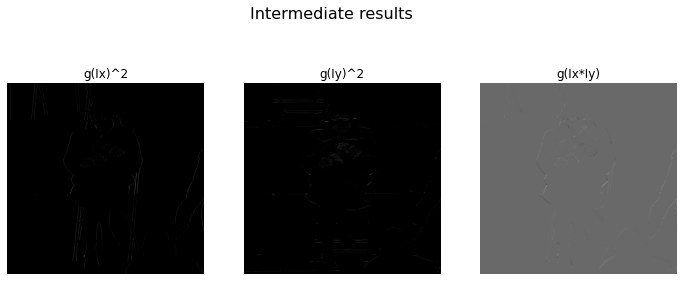

In [67]:
%lprun -f HarrisPointsDetector detected_kp = HarrisPointsDetector(gray_bernie)

mu=265327.6|sigma=5165972.5
600380544.0|-22357016.0


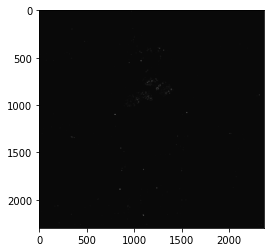

In [68]:
print(f"mu={np.mean(corner_strength_img):.1f}|sigma={np.std(corner_strength_img):.1f}")
print(f"{np.max(corner_strength_img)}|{np.min(corner_strength_img)}")
plt.imshow(corner_strength_img, cmap='gray')
plt.show()

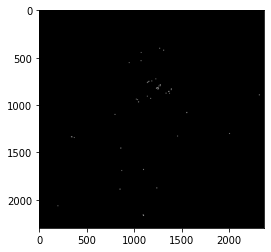

In [69]:
plt.imshow(corner_strength_img>=100000000, cmap='gray')

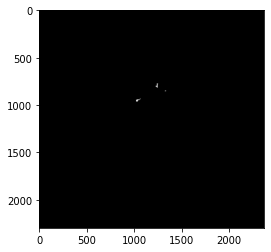

In [70]:
plt.imshow(scipy.ndimage.gaussian_filter(corner_strength_img>=100000, sigma=50, radius=20), cmap='gray')

## 1.2 Threshold strongest points [2 marks]
Plot the effect of different threshold values

In [71]:
def count_thresholded_corners(corner_strength_img: np.ndarray, threshold: int) -> int:
  thresholded = corner_strength_img >= threshold
  return np.count_nonzero(thresholded)

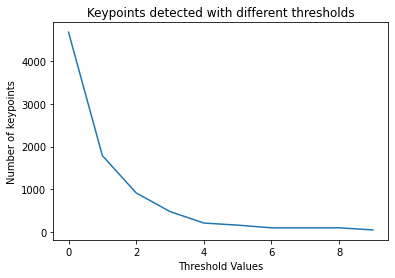

In [72]:
plt.title("Keypoints detected with different thresholds")
plt.xlabel("Threshold Values")
plt.ylabel("Number of keypoints")
plt.plot([count_thresholded_corners(corner_strength_img, corner_strength_img.max()*(t/10)) for t in range(1, 11)])

(2296, 2371)


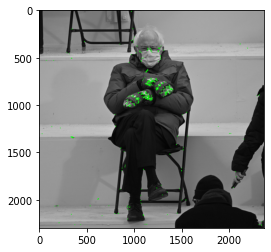

In [73]:
print(corner_strength_img.shape)
gray_bernie_with_kp = cv2.cvtColor(np.copy(gray_bernie), cv2.COLOR_GRAY2RGB)
gray_bernie_with_kp[corner_strength_img>(corner_strength_img.max()*(1/50))] = (0,255,0)
plt.imshow(gray_bernie_with_kp)

# 2. Feature Description [2 marks]

### 2.1 Using Built-In Methods

(< cv2.KeyPoint 0x7feb45d52480>, < cv2.KeyPoint 0x7feb45d524b0>, < cv2.KeyPoint 0x7feb45d52540>, < cv2.KeyPoint 0x7feb45d525a0>, < cv2.KeyPoint 0x7feb45d52570>, < cv2.KeyPoint 0x7feb45d52600>, < cv2.KeyPoint 0x7feb45d52630>, < cv2.KeyPoint 0x7feb45d52660>, < cv2.KeyPoint 0x7feb45d52690>, < cv2.KeyPoint 0x7feb45d526c0>, < cv2.KeyPoint 0x7feb45d526f0>, < cv2.KeyPoint 0x7feb45d52450>, < cv2.KeyPoint 0x7feb45d52720>, < cv2.KeyPoint 0x7feb45d52750>, < cv2.KeyPoint 0x7feb45d52780>, < cv2.KeyPoint 0x7feb45d527b0>, < cv2.KeyPoint 0x7feb45d527e0>, < cv2.KeyPoint 0x7feb45d52810>, < cv2.KeyPoint 0x7feb45d52840>, < cv2.KeyPoint 0x7feb45d52870>, < cv2.KeyPoint 0x7feb45d52300>, < cv2.KeyPoint 0x7feb45d522d0>, < cv2.KeyPoint 0x7feb45d528a0>, < cv2.KeyPoint 0x7feb45d528d0>, < cv2.KeyPoint 0x7feb45d52900>, < cv2.KeyPoint 0x7feb45d52930>, < cv2.KeyPoint 0x7feb45d52960>, < cv2.KeyPoint 0x7feb45d52420>, < cv2.KeyPoint 0x7feb45d52990>, < cv2.KeyPoint 0x7feb45d529c0>, < cv2.KeyPoint 0x7feb45d529f0>, < cv2.K

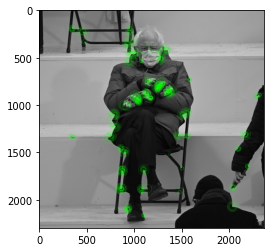

(<matplotlib.image.AxesImage at 0x7feb45934460>, None)

In [74]:
orb = cv2.ORB_create(nfeatures=500, scoreType=cv2.ORB_HARRIS_SCORE)
harris_kp, des = orb.detectAndCompute(gray_bernie,None)
print(harris_kp)
print(harris_kp[0].pt)
print(harris_kp[0].size)
print(harris_kp[0].angle)
gray_bernie_w_harris = cv2.drawKeypoints(gray_bernie, harris_kp, None, color=(0,255,0),
                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(gray_bernie_w_harris), plt.show()

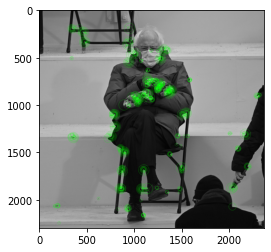

(<matplotlib.image.AxesImage at 0x7feb1b3d5c40>, None)

In [75]:
orb = cv2.ORB_create(nfeatures=500, scoreType=cv2.ORB_FAST_SCORE)
kp = orb.detect(gray_bernie,None)
kp, des = orb.compute(gray_bernie, kp)
img2 = cv2.drawKeypoints(gray_bernie, kp, None, color=(0,255,0),
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2), plt.show()

### 2.2 Using Keypoints Detected By Me

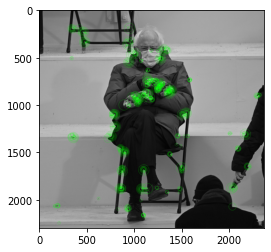

(<matplotlib.image.AxesImage at 0x7feb1d5222b0>, None)

In [76]:
orb = cv2.ORB_create(nfeatures=500, scoreType=cv2.ORB_FAST_SCORE)
kp, des = orb.compute(gray_bernie, kp)
img2 = cv2.drawKeypoints(gray_bernie, kp, None, color=(0,255,0),
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2), plt.show()

# 3. Feature Matching [2 marks]

In [77]:
def SSDFeatureMatcher(img_a, img_b) -> cv2.DMatch:
  pass

In [78]:
def RatioFeatureMatcher(img_a, img_b) -> cv2.DMatch:
  pass

In [79]:
def matchFeatures():
  pass